In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt

In [2]:
df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0}
eq = kumamoto

df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=75, m=1)
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

In [3]:
def calc_b_with_time_window(dataframe, n_eq, time_window_center):
    df_window = dataframe.copy()
    time_window_index = df_window.index.get_loc(time_window_center, method='pad')
    df_window = df_window.ix[time_window_index - n_eq : time_window_index + n_eq]
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_window.mag)
    return a, b, bstd, n, mc, time_window_index

In [4]:
time_window_centers = pd.date_range('01-01-1991', eq['time'], freq='3m')
time_window_centers[50]

Timestamp('2003-07-31 00:00:00', freq='3M')

In [5]:
df.between_time(start_time=time_window_centers[50], end_time=time_window_centers[51])

ValueError: Cannot convert arg [Timestamp('2003-07-31 00:00:00', freq='3M')] to a time

In [6]:
df.ix[df_regional.index.get_loc(time_window_centers[50], method='pad')]

lon                  138.675000
lat                   33.563333
decimal_year        1991.782927
month                 10.000000
day                   13.000000
mag                    2.700000
depth                 41.000000
hour                  18.000000
minute                26.000000
second                30.300000
horizontal_error       1.929859
depth_error                 NaN
mag_err                     NaN
Name: 1991-10-13 18:26:30.300007, dtype: float64

In [7]:
calc_b_with_time_window(df_regional, 500, time_window_centers[50])

(3.4696639347306002,
 0.94300602870761829,
 0.036996189018512891,
 645,
 0.69999999999999996,
 19646)

In [8]:
b_over_time = []

r = 15
df_local = df_regional[df_regional.distance <= r].copy()

for t in time_window_centers:
    row = (t,) + calc_b_with_time_window(dataframe=df_regional, n_eq=1000, time_window_center=t)
    b_over_time.append(row)

In [9]:
b_over_time = np.array(b_over_time)
bt_df = pd.DataFrame(b_over_time, columns=['time', 'a', 'b', 'bstd', 'n', 'mc', 't_index'])
bt_df = bt_df.set_index(bt_df['time'])

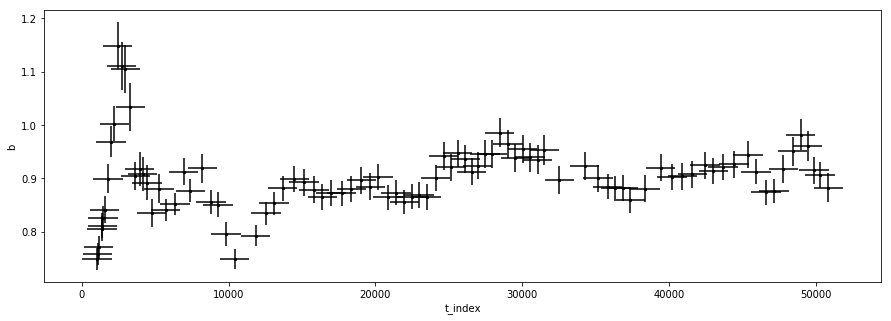

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

bt_df.plot(ax=ax, kind='scatter', yerr='bstd', xerr=1000, x='t_index', y='b'
          ,color='black', edgecolor='black', marker='.')

# ax.set_xticks(bt_df.t_index)

(0.5, 2.0)

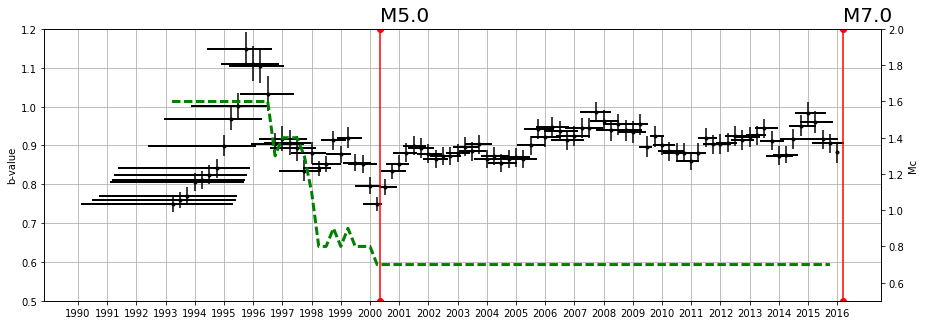

In [49]:
fig, ax = plt.subplots(figsize=(15,5))
ax.errorbar(x=time_window_centers, y=bt_df.b, yerr=bt_df.bstd, fmt='o'
           ,color='black', marker='.')

ax.set_ylabel('b-value')
ax.set_ylim(0.5, 1.2)

ax.set_xticks(pd.date_range('01-01-1990', eq['time'], freq='12m'))

# ax.scatter(x=pd.to_datetime('06-13-1997'), y=0.65, marker='*', s=150)

mc_y = []
mc_x = []
for mc, y, t in zip(bt_df.mc.values, bt_df.b.values, time_window_centers):
    try:
        tix = df_regional.index.get_loc(t, method='pad')
        lower_t = df_regional.ix[tix - 1000].name
        upper_t = df_regional.ix[tix + 1000].name
        middle_t = df_regional.ix[tix].name
        
        ax.plot_date(x=[lower_t, upper_t], y=(y, y), linewidth=2, marker='None', linestyle='-'
                    ,color='black')
        
        mc_y.append(mc)
        mc_x.append(middle_t)
    except IndexError:
        pass

ax.grid(True)

x = pd.to_datetime(['2000-06-08 00:32:46.129979', '2000-06-08 00:32:46.129979'])

ax.plot_date(x, y=[0.5, 1.2], linestyle='-', color='red')
ax.text(s='M5.0', x=x[0], y= 1.22, fontsize=20)

ax.plot_date(x=[upper_t, upper_t], y=(0.5, 1.2), linestyle='-', color='red')
ax.text(s='M7.0', x=upper_t, y=1.22, fontsize=20)

ax2 = ax.twinx()

ax2.plot_date(mc_x, mc_y, linestyle='--', color='green', marker='', linewidth=3
             , zorder=0)
ax2.set_ylabel('Mc')
ax2.set_ylim(0.5, 2.0)

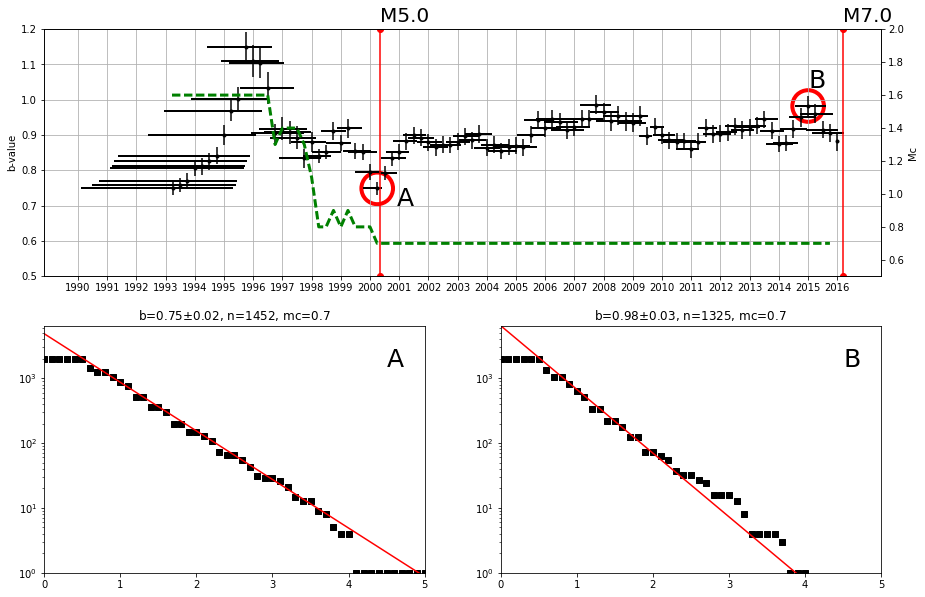

In [137]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, sharex=ax3, sharey=ax3)

ax.errorbar(x=time_window_centers, y=bt_df.b, yerr=bt_df.bstd, fmt='o'
           ,color='black', marker='.')

ax.set_ylabel('b-value')
ax.set_ylim(0.5, 1.2)

ax.set_xticks(pd.date_range('01-01-1990', eq['time'], freq='12m'))

# ax.scatter(x=pd.to_datetime('06-13-1997'), y=0.65, marker='*', s=150)

mc_y = []
mc_x = []
for mc, y, t in zip(bt_df.mc.values, bt_df.b.values, time_window_centers):
    try:
        tix = df_regional.index.get_loc(t, method='pad')
        lower_t = df_regional.ix[tix - 1000].name
        upper_t = df_regional.ix[tix + 1000].name
        middle_t = df_regional.ix[tix].name
        
        ax.plot_date(x=[lower_t, upper_t], y=(y, y), linewidth=2, marker='None', linestyle='-'
                    ,color='black')
        
        mc_y.append(mc)
        mc_x.append(middle_t)
    except IndexError:
        pass

ax.grid(True)

x = pd.to_datetime(['2000-06-08 00:32:46.129979', '2000-06-08 00:32:46.129979'])

ax.plot_date(x, y=[0.5, 1.2], linestyle='-', color='red')
ax.text(s='M5.0', x=x[0], y= 1.22, fontsize=20)

ax.plot_date(x=[upper_t, upper_t], y=(0.5, 1.2), linestyle='-', color='red')
ax.text(s='M7.0', x=upper_t, y=1.22, fontsize=20)

ax2 = ax.twinx()

ax2.plot_date(mc_x, mc_y, linestyle='--', color='green', marker='', linewidth=3
             , zorder=0)
ax2.set_ylabel('Mc')
ax2.set_ylim(0.5, 2.0)

bt_min = ('2000-04-30', 0.749104)
bt_max = ('2015-01-31', 0.982399)

###########################
# minimum b-value
x = pd.to_datetime('2000-04-30')
tix = df_regional.index.get_loc(x, method='pad')
mags = df_regional.ix[tix-1000 : tix+1000]

ax.scatter(x, y=bt_min[1], marker='o', s=1000, edgecolor='Red', color='None', zorder=0
          ,linewidth=4)
ax.text(s='A', x='2001-01-01', y=bt_min[1]-0.05, fontsize=25)
plotting.plot_fmd_diagram(mags, fig, ax3)
ax3.text(s='A', x=4.5, y=1.5e3, fontsize=25)


##########################
# maximum b-value
x = pd.to_datetime('2015-01-31')
tix = df_regional.index.get_loc(x, method='pad')
mags = df_regional.ix[tix-1000 : tix+1000]

ax.scatter(x, y=bt_max[1], marker='o', s=1000, edgecolor='Red', color='None', zorder=0
          ,linewidth=4)
ax.text(s='B', x=x, y=bt_max[1]+0.05, fontsize=25)
plotting.plot_fmd_diagram(mags, fig, ax4)
ax4.text(s='B', x=4.5, y=1.5e3, fontsize=25)


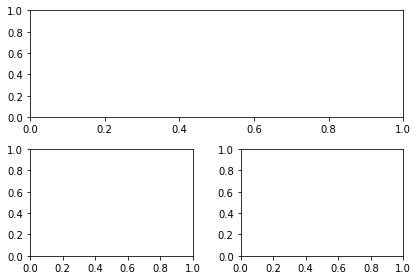

In [95]:
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
# ax4 = plt.subplot2grid((2, 3), (2, 0))
# ax5 = plt.subplot2grid((2, 3), (2, 1))

plt.tight_layout()

In [ ]:
bt_min = ('2000-04-30', 0.749104)
bt_max = ('2015-01-31', 0.982399)

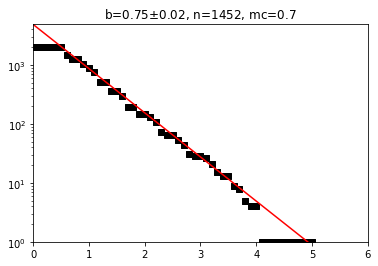

In [69]:
tix = df_regional.index.get_loc(pd.to_datetime('2000-04-30'), method='pad')
mags = df_regional.ix[tix-1000 : tix+1000]
# a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(mags)

fig, ax = plt.subplots()
plotting.plot_fmd_diagram(mags, fig, ax)

In [55]:
bt_df.b.sort_values()

time
2000-04-30    0.749104
1993-04-30    0.749234
1993-07-31    0.758567
1993-10-31    0.771075
2000-07-31    0.792839
2000-01-31    0.796484
1994-01-31    0.806066
1994-04-30    0.811262
1994-07-31    0.825275
2000-10-31     0.83472
1997-10-31    0.834861
1998-04-30    0.840947
1994-10-31    0.841695
1999-10-31    0.851212
1998-07-31    0.852458
2001-01-31    0.853185
2004-07-31     0.85561
1999-07-31    0.856001
2011-01-31    0.859831
2004-01-31    0.864706
2002-04-30    0.865256
2005-04-30    0.865519
2004-10-31    0.865595
2005-01-31    0.869382
2002-10-31    0.871981
2002-07-31    0.872558
2004-04-30    0.873333
2014-01-31    0.874052
2014-04-30    0.876654
1999-01-31    0.877131
                ...   
2006-07-31    0.936386
2008-04-30     0.93892
2008-10-31    0.939458
2005-10-31    0.941772
2013-07-31    0.944536
2007-07-31    0.945403
2007-04-30    0.945602
2006-04-30    0.946892
2014-10-31    0.951083
2009-04-30    0.954065
2008-07-31    0.955001
2015-04-30    0.961036
2008-0

In [23]:
df[(df.decimal_year > 2000) & (df.decimal_year < 2001) & (df.mag > 4.9) & df.lon.between(130, 131)
  & df.lat.between(32, 33)]

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err
timestamp,,,,,,,,,,,,,
2000-06-08 00:32:46.129979,130.762,32.692333,2000.434488,6.0,8.0,5.0,10.31,0.0,32.0,46.130001,0.466253,0.84,NaN


In [ ]:
df_regional.index.get_loc(time_window_centers[75], method='pad')

In [ ]:
tix = df_regional.index.get_loc(time_window_centers[75], method='pad')
lower_t = df_regional.ix[tix-1000].name
upper_t = df_regional.ix[tix+1000].name

In [ ]:
bt_df.index

In [ ]:
df.ix[296]